In [1]:
!pip install --upgrade scikit-learn imbalanced-learn

  Using cached scikit_learn-1.7.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)


In [3]:
import pandas as pd
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Flatten, Activation, LSTM, Bidirectional, Add, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [7]:
data_dir = "Final_Dataset/"

In [9]:
max_len = 300
feature_dim = 45
SAMPLE_RATE = 16000

sequences = []
labels = []

def load_and_preprocess(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)

    # 1️⃣ Trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=30)

    # 2️⃣ Normalize to [-1.0, 1.0]
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y

    return y

def extract_features(y, sr=SAMPLE_RATE, max_len=300):
    # MFCC + delta + delta-delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y=y)

    # Pitch using YIN
    try:
        f0 = librosa.yin(y=y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        f0 = f0.reshape(1, -1)
    except:
        f0 = np.zeros((1, mfcc.shape[1]))

    # All features should match MFCC's time dimension (T)
    T = mfcc.shape[1]

    def resize(feat):
        return feat[:, :T] if feat.shape[1] >= T else np.pad(feat, ((0, 0), (0, T - feat.shape[1])), mode='constant')

    # Stack all features vertically
    all_features = np.vstack([
        mfcc,              # (13, T)
        delta1,            # (13, T)
        delta2,            # (13, T)
        resize(centroid),  # (1, T)
        resize(bandwidth), # (1, T)
        resize(rolloff),   # (1, T)
        resize(rms),       # (1, T)
        resize(zcr),       # (1, T)
        resize(f0)         # (1, T)
    ])  # → (45, T)

    # Transpose to shape: (T, 45)
    features = all_features.T  # → (T, 45)

    # Pad or truncate to (300, 45)
    if features.shape[0] < max_len:
        pad_width = max_len - features.shape[0]
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    else:
        features = features[:max_len, :]

    return features  # Final shape: (300, 45)

In [11]:
for file in os.listdir(data_dir):
    if not file.endswith('.wav'):
        continue

    # Emotion code is 8th character (index 6 if zero-indexed, or 7 if you were correct)
    code = file[7]  # Make sure this matches your filename pattern

    if   code == '1':
        label = 'neutral'
    elif code == '2':
        label = 'calm'
    elif code == '3':
        label = 'happy'
    elif code == '4':
        label = 'sad'
    elif code == '5':
        label = 'angry'
    elif code == '6':
        label = 'fearful'
    elif code == '7':
        label = 'disgust'
    elif code == '8':
        label = 'surprised'
    else:
        continue  # unknown label, skip

    file_path = os.path.join(data_dir, file)

    y = load_and_preprocess(file_path, sr=SAMPLE_RATE)
    feature_vector = extract_features(y, sr=SAMPLE_RATE)

    sequences.append(feature_vector)
    labels.append(label)


In [13]:
X = pad_sequences(
    sequences,
    maxlen=max_len,
    dtype='float32',
    padding='post',
    truncating='post'
)

In [15]:
X.shape

(2070, 300, 45)

In [17]:
le = LabelEncoder()
y_int = le.fit_transform(labels)
y = to_categorical(y_int)

In [19]:
print("Total samples:", len(labels))
print("X shape:", X.shape)   # → (n_samples, max_len, 33)
print("y shape:", y.shape)   # → (n_samples,)

Total samples: 2070
X shape: (2070, 300, 45)
y shape: (2070, 8)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [23]:
num_features = X.shape[2]  # e.g., 36
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, num_features)
scaler.fit(X_train_2d)

StandardScaler()

In [25]:
X_train_scaled = scaler.transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val.reshape(-1, num_features)).reshape(X_val.shape)

In [27]:
X_train = X_train_scaled
X_val = X_val_scaled

In [29]:
y_val.shape

(414, 8)

In [31]:
# suppose X.shape == (n_samples, timesteps, feat_dim)
n_samples, timesteps, feat_dim = X_train.shape

# 1) flatten
X_flat = X_train.reshape(n_samples, timesteps * feat_dim)

# 2) resample
smote = SMOTE(random_state=42)
X_flat_res, y_res = smote.fit_resample(X_flat, y_train)

# 3) reshape back to sequences
n_resampled = X_flat_res.shape[0]
X_res = X_flat_res.reshape(n_resampled, timesteps, feat_dim)

print("Resampled shapes:", X_res.shape, y_res.shape)

Resampled shapes: (2408, 300, 45) (2408, 8)


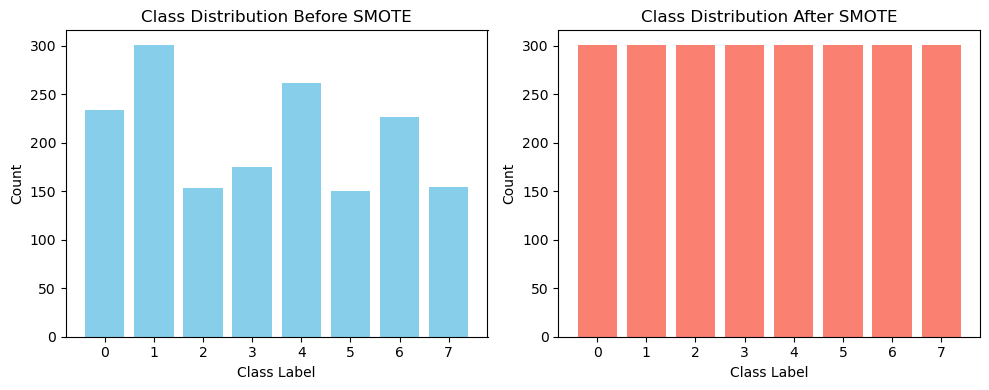

In [33]:
y_orig = np.argmax(y_train, axis=1)
y_resampled = np.argmax(y_res, axis=1)

# Get sorted list of classes
classes = np.unique(np.concatenate((y_orig, y_resampled)))

# Count occurrences
counts_before = [(y_orig == cls).sum() for cls in classes]
counts_after  = [(y_resampled == cls).sum() for cls in classes]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(classes, counts_before, color='skyblue')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Count')

axes[1].bar(classes, counts_after, color='salmon')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [35]:
def add_noise(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

def random_time_scaling(X, scale_range=(0.9, 1.1)):
    scaled = []
    for seq in X:
        factor = np.random.uniform(*scale_range)
        scaled.append(seq * factor)
    return np.array(scaled)

def time_mask(X, max_mask_size=5):
    X_masked = X.copy()
    for i in range(X.shape[0]):
        t = np.random.randint(0, X.shape[1] - max_mask_size)
        X_masked[i, t:t+max_mask_size, :] = 0
    return X_masked

X_augmented_noise = add_noise(X_res)
X_augmented_scaled = random_time_scaling(X_res)
X_augmented_masked = time_mask(X_res)

X_aug = np.concatenate([X_res, X_augmented_noise, X_augmented_scaled, X_augmented_masked], axis=0)
y_aug = np.concatenate([y_res] * 4, axis=0)

print("Augmented shape:", X_aug.shape, y_aug.shape)

Augmented shape: (9632, 300, 45) (9632, 8)


In [37]:
num_classes = y.shape[1]  # One-hot encoded → shape (num_samples, num_classes)
input_shape = (300, 45)   # From your feature extractor

model = Sequential()

# 1️⃣ First Conv Block
model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# 2️⃣ Second Conv Block
model.add(Conv1D(256, kernel_size=5, activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# 3️⃣ Third Conv Block (Optional but helpful)
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# 4️⃣ Flatten before Dense
model.add(Flatten())

# 5️⃣ Dense Layer
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# 6️⃣ Output Layer
model.add(Dense(num_classes, activation='softmax'))

# 7️⃣ Compile with label smoothing
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 300, 128)       │        28,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 75, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       606,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,872 (3.44 MB)

 Trainable params: 899,848 (3.43 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [39]:
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(label_smoothing=0.1),  # ✅ smoothing
    metrics=['accuracy']
)

In [41]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
history = model.fit(
    X_aug, y_aug,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1684 - loss: 4.2462
Epoch 1: val_loss improved from inf to 2.60853, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.1684 - loss: 4.2435 - val_accuracy: 0.2222 - val_loss: 2.6085 - learning_rate: 0.0010
Epoch 2/200
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2362 - loss: 2.4961
Epoch 2: val_loss improved from 2.60853 to 2.10906, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.2364 - loss: 2.4955 - val_accuracy: 0.3696 - val_loss: 2.1091 - learning_rate: 0.0010
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3701 - loss: 2.1393
Epoch 3: val_loss improved from 2.10906 to 1.85754, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.3702 - loss: 2.1391 - val_accuracy: 0.5386 - val_loss: 1.8575 - learning_rate: 0.0010
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - 

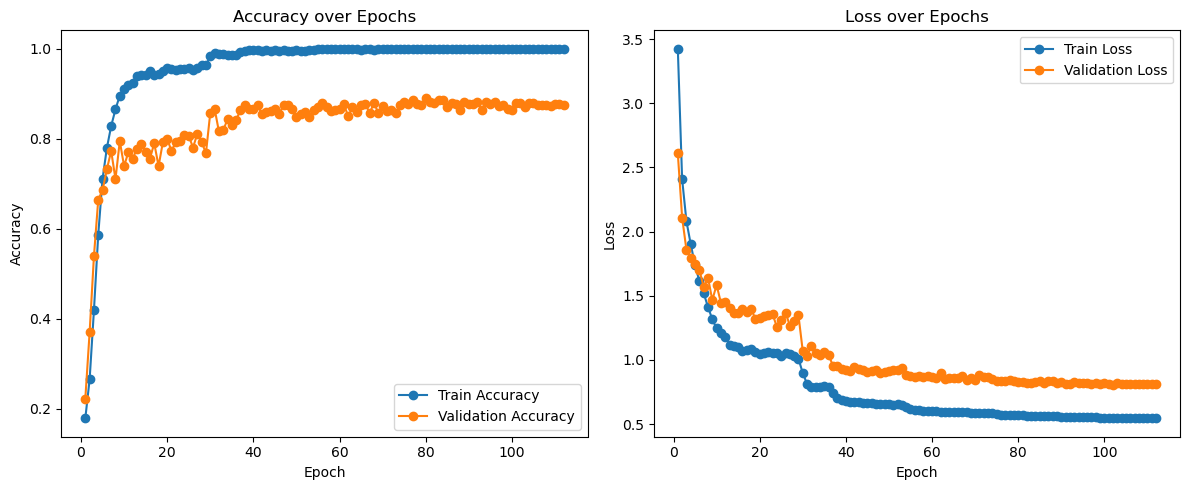

In [43]:
# Pull out the values for each metric
acc      = history.history.get('accuracy', history.history.get('acc'))
val_acc  = history.history.get('val_accuracy', history.history.get('val_acc'))
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# 1) Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,      marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc,  marker='o', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2) Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,      marker='o', label='Train Loss')
plt.plot(epochs, val_loss,  marker='o', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Predictions → Probabilities → Class Indices
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert one-hot labels to class indices
y_val_true = np.argmax(y_val, axis=1)

# Accuracy Scores
val_acc = accuracy_score(y_val_true, y_val_pred)

print(f"✅ Validation Accuracy: {val_acc:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
✅ Validation Accuracy: 0.8792


In [47]:
emotion_labels = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

# 2️⃣ Compute confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# 3️⃣ Normalize (optional)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


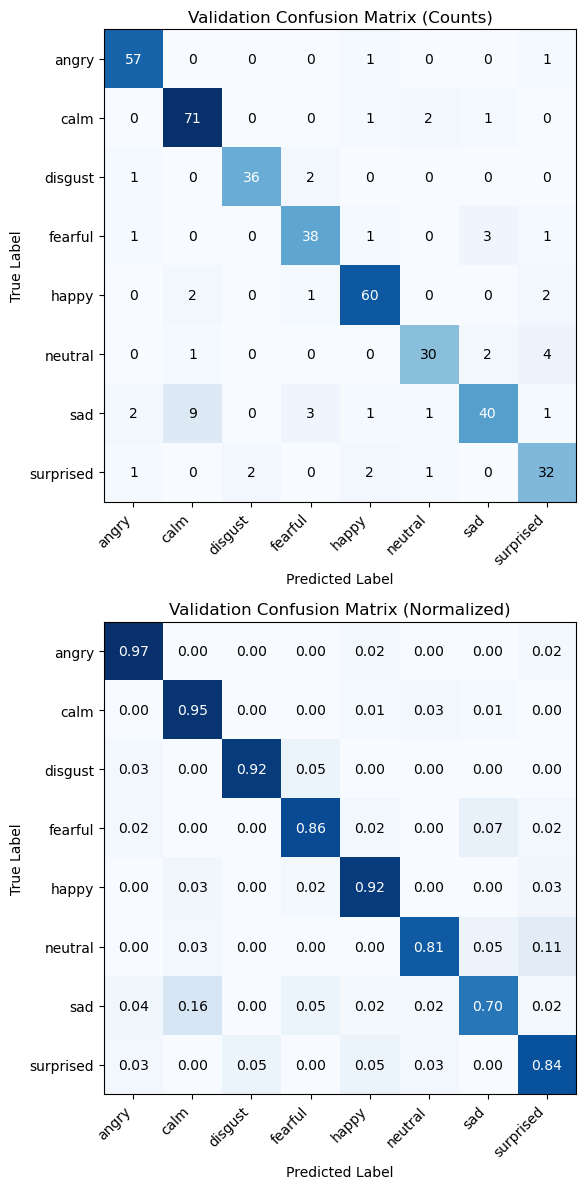

In [55]:
class_names = list(le.classes_)
num_classes = len(class_names)
tick_marks = np.arange(num_classes)

# 4) Plot all 4 matrices
fig, axes = plt.subplots(2, figsize=(16, 12))

# Confusion Matrix - Validation (Counts)
axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title("Validation Confusion Matrix (Counts)")
axes[0].set_xticks(tick_marks)
axes[0].set_yticks(tick_marks)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_yticklabels(class_names)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
for i in range(num_classes):
    for j in range(num_classes):
        axes[0].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max()/2 else "black")

# Confusion Matrix - Validation (Normalized)
axes[1].imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title("Validation Confusion Matrix (Normalized)")
axes[1].set_xticks(tick_marks)
axes[1].set_yticks(tick_marks)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_yticklabels(class_names)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
for i in range(num_classes):
    for j in range(num_classes):
        axes[1].text(j, i, f"{cm_norm[i, j]:.2f}",
                        ha="center", va="center",
                        color="white" if cm_norm[i, j] > 0.5 else "black")

# axes[1, 0].axis('off')
# axes[1, 1].axis('off')
plt.tight_layout()
plt.show()


In [57]:
import numpy as np
from sklearn.metrics import f1_score

def evaluate_f1_score(model, X_test, y_test, average='weighted'):
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)       # Convert from one-hot/prob to class index
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test  # Handle one-hot

    return f1_score(y_true, y_pred, average=average)


In [59]:
f1 = evaluate_f1_score(model, X_val, y_val)
print(f"F1 Score: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
F1 Score: 0.8776
